max_dist 5935.0
eig_val[:10] [0.         0.         0.         0.00174574 0.00860943 0.01745835
 0.02143826 0.03495575 0.04032973 0.04504305]
j:  3
[0.00174574 0.00860943]


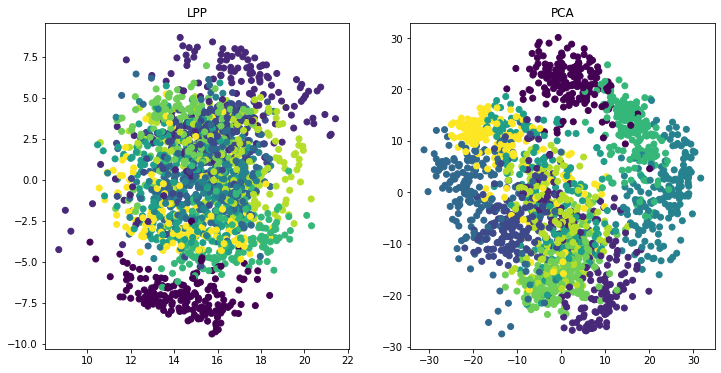

In [11]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn. decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_digits, load_iris


def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

def rbf(dist, t = 1.0):
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):

    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1 + n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

def lpp(data,
        n_dims = 2,
        n_neighbors = 30, t = 1.0):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)

    for i in range(N):
        D[i,i] = np.sum(W[i])

    L = D - W
    XDXT = np.dot(np.dot(data.T, D), data)
    XLXT = np.dot(np.dot(data.T, L), data)

    eig_val, eig_vec = np.linalg.eig(np.dot(np.linalg.pinv(XDXT), XLXT))

    sort_index_ = np.argsort(np.abs(eig_val))
    eig_val = eig_val[sort_index_]
    print("eig_val[:10]", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    # print(sort_index_)
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    data_ndim = np.dot(data, eig_vec_picked)

    return data_ndim

if __name__ == '__main__':
    X = load_digits().data
    y = load_digits().target
    # X, y = make_swiss_roll(n_samples = 1000)

    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    print("max_dist", max_dist)

    data_2d = lpp(X, n_neighbors = 5, t = 0.01*max_dist)
    data_2 = PCA(n_components=2).fit_transform(X)


    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("LPP")
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c = y)

    plt.subplot(122)
    plt.title("PCA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = y)
    plt.show()

